# Hotspot Calculations for HEP

Author: Brain Gravelle (gravelle@cs.uoregon.edu)


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/


## Imports
This section imports necessary libraies, the metrics.py and utilities.py files and sets up the window.

In [1]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

## Getting Data

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit. The first six experiments use the --num-thr option to set the thread count which is intended to perform threading within the events. the last two add the --num-ev-thr option to set the event threads, so that all threads are used to process events in parallel and each event is processed by a single thread. 
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode
* ev_thr_scaling_Large_talapas
* ev_thr_scaling_Large_talapas_fullnode

Additionally available in the cori_scaling application are the following. These were run on NERSC's Cori on the KNL with the default memory settings (quad - 1 NUMA domain, cache - MCDRAM as direct mapped cache). See http://www.nersc.gov/users/computational-systems/cori/running-jobs/advanced-running-jobs-options/ for more info on the KNL modes. Similar to the talapas scaling they use the build-ce option and threading within each event.
* manual_scaling_TTbar35
* manual_scaling_TTbar70
* manual_scaling_Large
* mixed_thr_scaling_Large


### Importing Scaling Data
Here we import the data. In this case we are using Cori data from the experiments with the threads working within each event using the TTbar35 file. Note that this box will take 10 or more minutes to run; please go enjoy a coffee while you wait.

In [2]:
application = "talapas_scaling"
# experiment  = "manual_scaling_TTbar70_talapas"
experiment  = "manual_scaling_Large_talapas"
# experiment = "ev_thr_scaling_Large_talapas"

# application = "cori_scaling"
# experiment  = "manual_scaling_TTbar35"
# experiment  = "manual_scaling_TTbar70"
# experiment  = "manual_scaling_Large"
# experiment  = "mixed_thr_scaling_Large"

path = ".tau/" + application + "/" + experiment + "/"
# note that this function takes a long time to run, so only rerun if you must
metric_data = get_pandas_scaling(path, callpaths=True)
if application == "talapas_scaling":
    metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 48, 56])
elif application == "cori_scaling":
    print(metric_data.keys())
    metric_data = remove_erroneous_threads(metric_data,  [1, 2, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256])

Possible missing metric: 
nthread = 1 
metric = PAPI_TLB_IM
Possible missing metric: 
nthread = 32 
metric = PAPI_SP_OPS
Possible missing metric: 
nthread = 8 
metric = PAPI_VEC_SP
Possible missing metric: 
nthread = 56 
metric = PAPI_L1_TCM
Possible missing metric: 
nthread = 1 
metric = PAPI_L3_TCA
Possible missing metric: 
nthread = 8 
metric = PAPI_TLB_IM
Possible missing metric: 
nthread = 32 
metric = PAPI_VEC_SP
Possible missing metric: 
nthread = 32 
metric = PAPI_L2_TCA
Possible missing metric: 
nthread = 18 
metric = PAPI_TLB_IM
Possible missing metric: 
nthread = 56 
metric = PAPI_TOT_INS


#### A list of metrics

In [3]:
print_available_metrics(metric_data,True)
print(metric_data.keys())

PAPI_BR_INS
PAPI_L3_TCA
PAPI_L2_TCA
PAPI_DP_OPS
PAPI_TLB_DM
PAPI_RES_STL
PAPI_VEC_DP
PAPI_L3_TCM
PAPI_L2_TCM
PAPI_TOT_INS
PAPI_TLB_IM
PAPI_SP_OPS
PAPI_LST_INS
PAPI_VEC_SP
PAPI_BR_CN
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_TOT_CYC
[32, 1, 48, 8, 16, 56]


#### Metric metadata

In [4]:
print_metadata(metric_data[8])

TAU_MAX_THREADS                                    112
TAU_CUDA_BINARY_EXE                                None
TAU_MEASURE_TAU                                    off
Memory Size                                        131916412 kB
TAU_TRACK_SIGNALS                                  off
TAU_TRACK_IO_PARAMS                                off
CPU MHz                                            1200.062
Local Time                                         2018-04-10T00:12:54-07:00
CPU Type                                           Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz
TAU_OUTPUT_CUDA_CSV                                off
TAU_EBS_INCLUSIVE                                  0 usec
Node Name                                          n029
TAU_CALLPATH_DEPTH                                 100
CPU Cores                                          14
OS Machine                                         x86_64
TAU_SAMPLING                                       on
Cache Size                              

## Adding metrics

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

Here we add some predeefined metrics and print the top 10 functions with the best IPC

In [5]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_IPC)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)
add_metric_to_scaling_data(metric_data, add_L3_missrate)
print_available_metrics(metric_data, scaling=True)

metric_data[1]['DERIVED_IPC'].sort_values(by='Inclusive',ascending=False).head(10)

PAPI_L2_TCA
PAPI_TLB_DM
PAPI_VEC_DP
PAPI_L2_TCM
DERIVED_CPI
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_DP_OPS
PAPI_RES_STL
PAPI_TOT_INS
PAPI_VEC_SP
PAPI_BR_CN
PAPI_L3_TCA
PAPI_TLB_IM
DERIVED_L1_MISSRATE
PAPI_L3_TCM
DERIVED_L3_MISSRATE
PAPI_SP_OPS
PAPI_BR_INS
DERIVED_L2_MISSRATE
DERIVED_IPC
PAPI_LST_INS
PAPI_TOT_CYC


Calls  \
thread region                                                                            
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.76e+00   
       [SUMMARY] Track::charge() const                                        1.76e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.50e+00   
       [SUMMARY] Track::Status::Status()                                      1.50e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.45e+00   
       [SUMMARY] void _INTERNALaa2588cd::KHMult_imp<Matriplex::Matriplex<f... 1.45e+00   
       [SUMMARY] std::vector<LayerOfHits, std::allocator<LayerOfHits> >::o... 1.48e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.48e+00   
       [SUMMARY] __svml_satan2_cout_rare                                      1.64e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.64e+00   

                                                                               Exclusive  \
thread region                                                                              
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.33e+00   
       [SUMMARY] Track::charge() const                                          3.33e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.07e+00   
       [SUMMARY] Track::Status::Status()                                        3.07e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.91e+00   
       [SUMMARY] void _INTERNALaa2588cd::KHMult_imp<Matriplex::Matriplex<f...   2.91e+00   
       [SUMMARY] std::vector<LayerOfHits, std::allocator<LayerOfHits> >::o...   2.84e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.84e+00   
       [SUMMARY] __svml_satan2_cout_rare                                        2.83e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.83e+00   

                                                                               Inclusive  \
thread region                                                                              
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.33e+00   
       [SUMMARY] Track::charge() const                                          3.33e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.07e+00   
       [SUMMARY] Track::Status::Status()                                        3.07e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.91e+00   
       [SUMMARY] void _INTERNALaa2588cd::KHMult_imp<Matriplex::Matriplex<f...   2.91e+00   
       [SUMMARY] std::vector<LayerOfHits, std::allocator<LayerOfHits> >::o...   2.84e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.84e+00   
       [SUMMARY] __svml_satan2_cout_rare                                        2.83e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.83e+00   

                                                                               ProfileCalls  \
thread region                                                                                 
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...           nan   
       [SUMMARY] Track::charge() const                                                  nan   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...           nan   
       [SUMMARY] Track::Status::Status()                                                nan   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...           nan   
       [SUMMARY] void _INTERNALaa2588cd::KHMult_imp<Matriplex::Matriplex<f...           nan   
       [SUMMARY] std::vector<L

## Scaling Results

In this section we demo some scaling results with several different metrics.

We use the scaling plot function to plot the data vs thread count.
scaling_plot(data, inclusive=True, plot=True, function="\[SUMMARY\] .TAU application$", metric='PAPI_TOT_CYC', max=False)
* data = the full dictionary of scaling data 
* inclusive = determines if the inclusive data or exclusive data will be used
* plot = true makes a plot false does not
* function = the string that will be searched for to plot. Default looks at the whole application
* metric = the metric choosen from the above list
* max = use the max value or average value across the threads

### Scaling with total cycles vs the thread count
Here we plot the cycle count for each thread count as a proxy for execution time. We use the max cycle count rather than the average as this number will limit the time of execution.

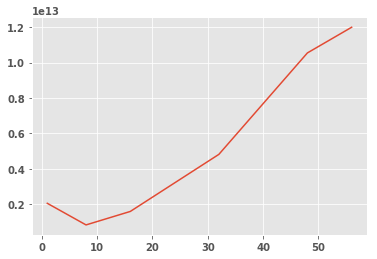

In [6]:
thread_list, tot_cyc_list = scaling_plot(metric_data, max=True)

### Cycles per thread for each thread count
Here we show load balancing with a series of plots showing the cycle count per thread. We have one plot for each thread count used

1


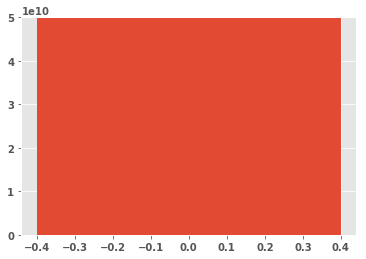

8


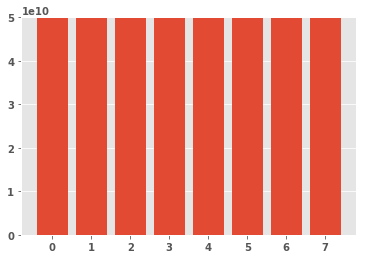

16


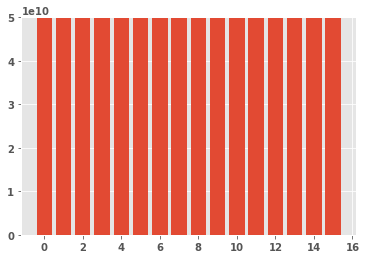

32


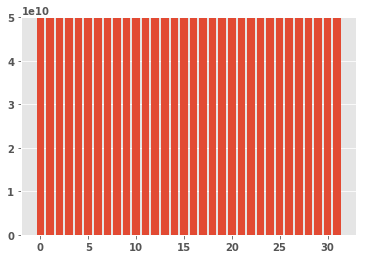

48


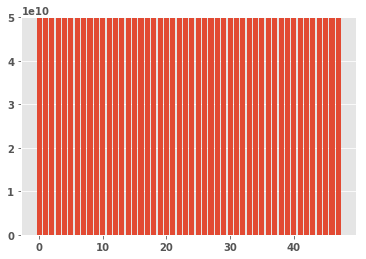

56


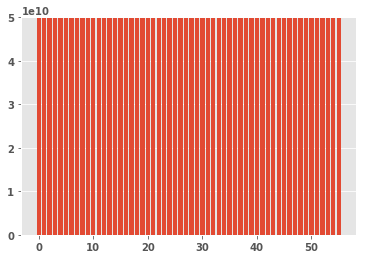

In [7]:
thread_cyc_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_TOT_CYC')

for kt in thread_list:
    print kt
    data = list(thread_cyc_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=50000000000) 
    matplotlib.pyplot.show()

### L1 Missrate vs thread count
Similar to above these cells show the L1 missrates. In this case we want to get the plotting data for L1 acceses and misses but comupte the miss rate before plotting, so we set plot=False

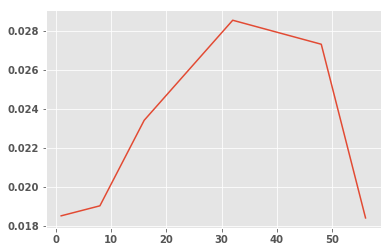

In [8]:
thread_list, L1A_data = scaling_plot(metric_data, plot=False, metric='PAPI_LST_INS')
thread_list, L1M_data = scaling_plot(metric_data, plot=False, metric='PAPI_L1_TCM')
    
L1_MR_list = [L1M_data[i] / L1A_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, L1_MR_list)

### L1 Miss rate by each thread of each thread count

thread
0   6.96e+12
Name: Inclusive, dtype: float64
thread
0   2.55e+12
1   6.33e+11
2   6.33e+11
3   6.29e+11
4   6.34e+11
5   6.32e+11
6   6.32e+11
7   6.31e+11
Name: Inclusive, dtype: float64
thread
0    2.15e+12
1    3.23e+11
2    3.22e+11
3    3.24e+11
4    3.26e+11
5    3.27e+11
6    3.24e+11
7    3.24e+11
8    3.22e+11
9    3.24e+11
10   3.21e+11
11   3.20e+11
12   3.24e+11
13   3.23e+11
14   3.22e+11
15   3.23e+11
Name: Inclusive, dtype: float64
thread
0    7.17e+12
1    1.81e+11
2    1.80e+11
3    1.81e+11
4    1.81e+11
5    1.81e+11
6    1.80e+11
7    1.81e+11
8    1.81e+11
9    1.79e+11
10   1.82e+11
11   1.81e+11
12   1.82e+11
13   1.82e+11
14   1.82e+11
15   1.81e+11
16   1.81e+11
17   1.80e+11
18   1.82e+11
19   1.80e+11
20   1.81e+11
21   1.81e+11
22   1.82e+11
23   1.81e+11
24   1.81e+11
25   1.82e+11
26   1.81e+11
27   1.81e+11
28   1.82e+11
29   1.82e+11
30   1.82e+11
31   1.80e+11
Name: Inclusive, dtype: float64
thread
0    1.88e+13
1    1.25e+11
2    1.25e+11
3    1

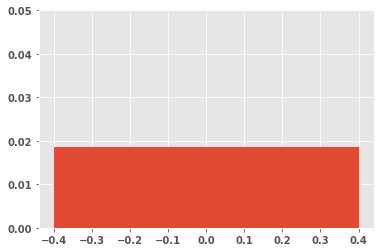

8


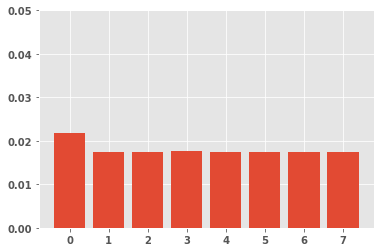

16


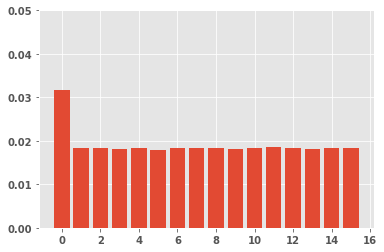

32


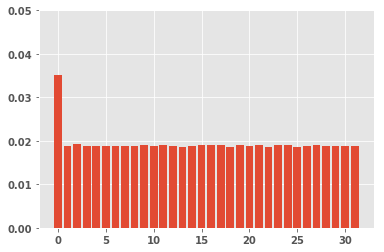

48


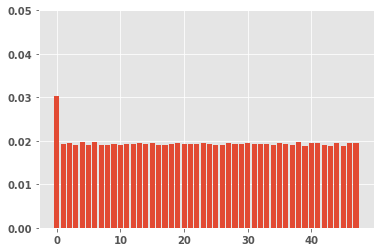

56


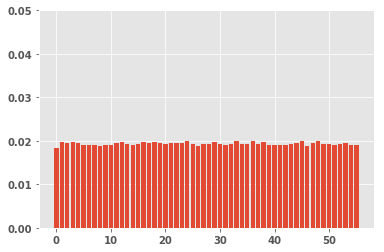

In [9]:
thread_L1A_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_LST_INS')
thread_L1M_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L1_TCM')

MR_data = {}
for kt in thread_list:
#     print(thread_L1M_data[kt])
    print(thread_L1A_data[kt])
    MR_data[kt] = thread_L1M_data[kt] / thread_L1A_data[kt]
    
for kt in thread_list:
    print kt
    data = list(MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.05)
    matplotlib.pyplot.show()

### L1 Top 10 bad miss rates

In [23]:
L1_data = select_metric_from_scaling(metric_data, 'DERIVED_L1_MISSRATE')
L1_MR_dict = {}
for n_thr in thread_list:
    L1_MR_dict[n_thr] = filter_libs_out(L1_data[n_thr]).sort_values(by='Inclusive',ascending=False)[["Inclusive"]]
print thread_list

[1, 8, 16, 32, 48, 56]


In [27]:
THREAD_COUNT = 16
L1_MR_dict[THREAD_COUNT].head(10)

Inclusive
thread region                                                                           
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.90e+01
       [SUMMARY] __lll_lock_wait_private                                        2.90e+01
6      [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::At(int, int, int)        2.09e-01
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.09e-01
10     [SUMMARY] LayerOfHits::set_phi_bin(int, int, int&, int&)                 1.73e-01
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.73e-01
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.14e-01
       [SUMMARY] Event::relabel_bad_seedtracks()                                1.14e-01
13     [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.02e-01
       [SUMMARY] __lll_lock_wait_private                                        1.02e-01

### L2 Missrate vs thread count
Similar to above these cells show the L2 missrates.

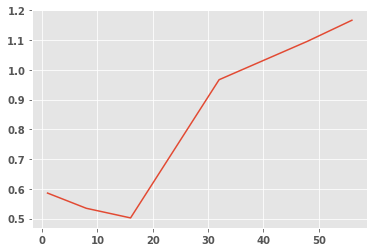

In [11]:
thread_list, L2A_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCA')
thread_list, L2M_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCM')
    
L2_MR_list = [L2M_data[i] / L2A_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, L2_MR_list)

1


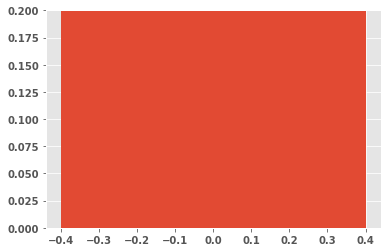

8


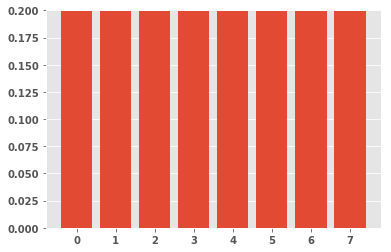

16


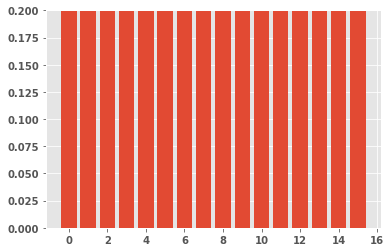

32


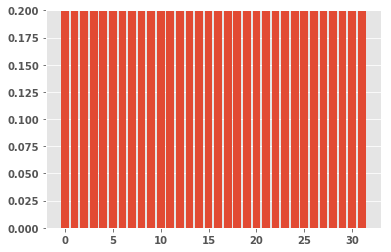

48


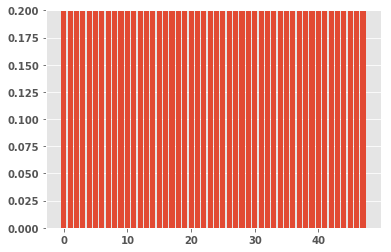

56


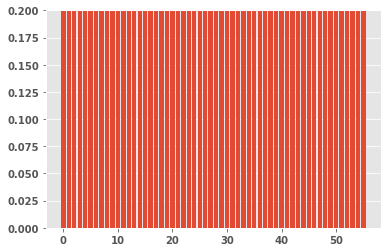

In [12]:
thread_L2A_data = get_thread_level_metric_scaling(select_metric_from_scaling(metric_data, 'PAPI_L2_TCA'))
thread_L2M_data = get_thread_level_metric_scaling(select_metric_from_scaling(metric_data, 'PAPI_L2_TCM'))


L2_MR_data = {}
for kt in thread_list:
    L2_MR_data[kt] = thread_L2M_data[kt] / thread_L2A_data[kt]
    
for kt in thread_list:
    print kt
    data = list(L2_MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.2)
    matplotlib.pyplot.show()

### L2 Top 10 bad miss rates

In [28]:
L2_data = select_metric_from_scaling(metric_data, 'DERIVED_L2_MISSRATE')
L2_MR_dict = {}
for n_thr in thread_list:
    L2_MR_dict[n_thr] = filter_libs_out(L2_data[n_thr]).sort_values(by='Inclusive',ascending=False)[["Inclusive"]]
print thread_list

[1, 8, 16, 32, 48, 56]


In [29]:
THREAD_COUNT = 16
L2_MR_dict[THREAD_COUNT].head(10)

Inclusive
thread region                                                                           
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.85e+00
       [SUMMARY] Event::relabel_bad_seedtracks()                                2.85e+00
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.66e+00
       [SUMMARY] Track::Status::Status()                                        2.66e+00
       [SUMMARY] __GI___libc_free                                               1.99e+00
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.99e+00
       [SUMMARY] _int_free                                                      1.97e+00
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.97e+00
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.95e+00
       [SUMMARY] Track::canReachRadius(float) const                             1.95e+00

### L3 Missrate vs thread count
Similar to above these cells show the L3 missrates.

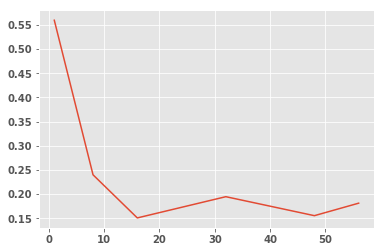

In [13]:
if application == 'talapas_scaling':
    thread_list, LLA_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCA')
    thread_list, LLM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCM')
else:
    thread_list, LLA_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_LLC_REFERENCES')
    thread_list, LLM_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_LLC_MISSES')
    
LL_MR_list = [LLM_data[i] / LLA_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, LL_MR_list)

1


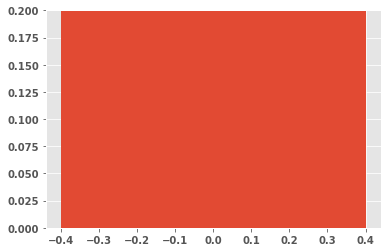

8


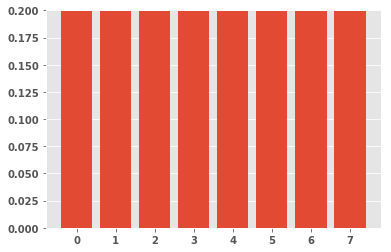

16


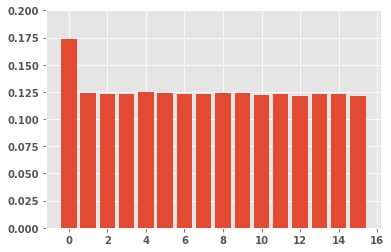

32


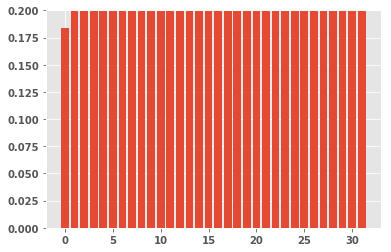

48


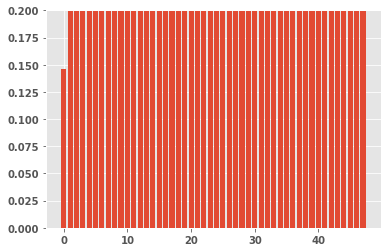

56


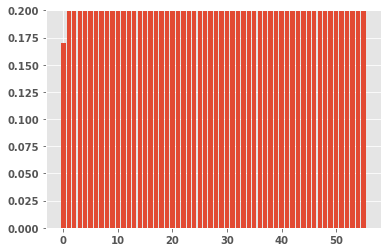

In [14]:
if application == 'talapas_scaling':
    thread_LLA_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCA')
    thread_LLM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCM')
else:
    thread_LLA_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_LLC_REFERENCES')
    thread_LLM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_LLC_MISSES')


LL_MR_data = {}
for kt in thread_list:
    LL_MR_data[kt] = thread_LLM_data[kt] / thread_LLA_data[kt]
    
for kt in thread_list:
    print kt
    data = list(LL_MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.2)
    matplotlib.pyplot.show()

### L1 Top 10 bad miss rates

In [30]:
L3_data = select_metric_from_scaling(metric_data, 'DERIVED_L3_MISSRATE')
L3_MR_dict = {}
for n_thr in thread_list:
    L3_MR_dict[n_thr] = filter_libs_out(L3_data[n_thr]).sort_values(by='Inclusive',ascending=False)[["Inclusive"]]
print thread_list

[1, 8, 16, 32, 48, 56]


In [32]:
THREAD_COUNT = 32
L3_MR_dict[THREAD_COUNT].head(10)

Inclusive
thread region                                                                           
16     [SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriple...   1.10e+00
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.10e+00
19     [SUMMARY] __svml_logf8_mask_e9                                           1.04e+00
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.04e+00
28     [SUMMARY] atan2f                                                         9.42e-01
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   9.42e-01
22     [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   9.15e-01
       [SUMMARY] (anonymous namespace)::AddIntoUpperLeft2x2(Matriplex::Mat...   9.15e-01
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   8.59e-01
       [SUMMARY] TrackState::pz() const                                         8.59e-01

###  Resource Stalls vs thread count
Similar to above these cells show the Resource Stalls. In this case we have nothing to compute, so we simply call the function. Future work includes exploring the different types of stalls.

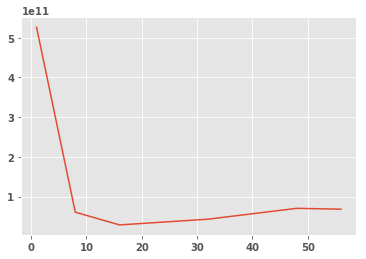

In [15]:
thread_list, res_stall_data = scaling_plot(metric_data, metric='PAPI_RES_STL')

1


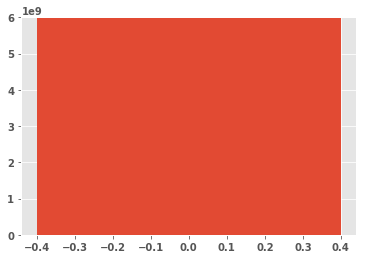

8


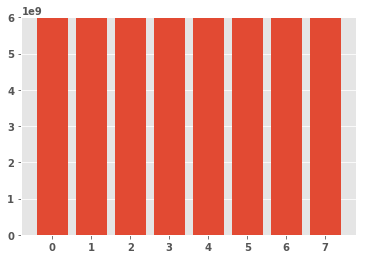

16


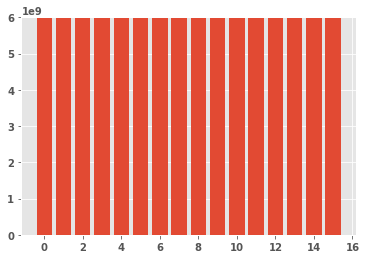

32


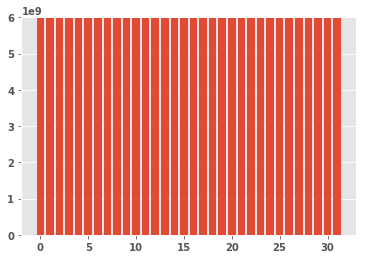

48


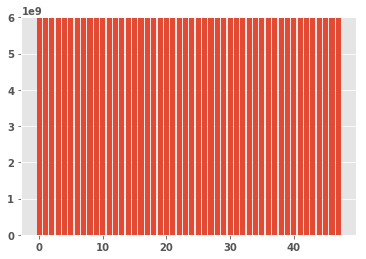

56


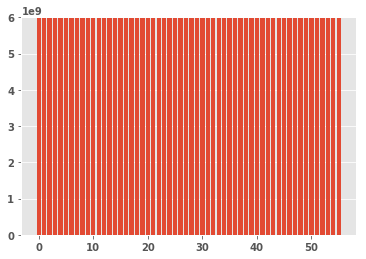

In [16]:
thread_stall_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_RES_STL')
    
for kt in thread_list:
    print kt
    data = list(thread_stall_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=6000000000)
    matplotlib.pyplot.show()